In [1]:
import numpy as np
import sklearn as sk
from sklearn import mixture, cluster,metrics, neural_network
import pandas as pd

In [2]:
df = pd.read_csv('data/train_image_features_CLIP_ViT-B32_output.csv',header=None)
x_train_image1 = df.to_numpy()

df = pd.read_csv('data/training_image_features_CLIP_RN50_output.csv',header=None)
x_train_image2 = df.to_numpy()

df = pd.read_csv('data/test_image_features_CLIP_ViT-B32_output.csv',header=None)
x_test_image1 = df.to_numpy()

df = pd.read_csv('data/test_image_features_CLIP_RN50_output.csv',header=None)
x_test_image2 = df.to_numpy()



df = pd.read_csv('data/early_train_text_features_CLIP_transformer.csv',header=None)
x_train_text_early = df.to_numpy()

df = pd.read_csv('data/early_test_text_features_CLIP_transformer.csv',header=None)
x_test_text_early = df.to_numpy()

df = pd.read_csv('data/middle_train_text_features_CLIP_transformer.csv',header=None)
x_train_text_middle = df.to_numpy()

df = pd.read_csv('data/middle_test_text_features_CLIP_transformer.csv',header=None)
x_test_text_middle = df.to_numpy()


df = pd.read_csv('data/training_text_features_CLIP_transformer_output.csv',header=None)
x_train_text_last = df.to_numpy()

df = pd.read_csv('data/test_text_features_CLIP_transformer_output.csv',header=None)
x_test_text_last = df.to_numpy()

data_image = []
data_image.append(np.concatenate((x_train_image1,x_test_image1), axis = 0))
data_image.append(np.concatenate((x_train_image2,x_test_image2), axis = 0))

data_text = []
data_text.append(np.concatenate((x_train_text_early,x_test_text_early), axis = 0))
data_text.append(np.concatenate((x_train_text_middle,x_test_text_middle), axis = 0))
data_text.append(np.concatenate((x_train_text_last,x_test_text_last), axis = 0))


In [3]:
import pandas as pd 
import json 

with open('./data/train.jsonl', 'r') as json_file:
    json_list = list(json_file)
  
text_list = list() # storing in lists
id_list = list()
labels_list = list()

for json_str in json_list: 
    result = json.loads(json_str)
    id_list.append(f"{result['id']}")

    text_list.append(f"{result['text']}")
    labels_list.append(f"{result['label']}")

with open('./data/test_seen.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list: 
    result = json.loads(json_str)
    id_list.append(f"{result['id']}")

    text_list.append(f"{result['text']}")
    labels_list.append(f"{result['label']}")
df = pd.DataFrame({"id": id_list, "text": text_list}) #converting into dataframes

df_label = pd.DataFrame({"id": id_list, "label": labels_list})

labels_true = df_label["label"].to_numpy().astype(int)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, schedules

In [31]:
def skip_model(input_size):
    inp = tf.keras.Input(input_size,)
    
    dense1 = Dense(256)(inp)
    act1 = LeakyReLU(0.1)(dense1)
    drop1 = Dropout(0.5)(act1)
    
    dense2 = Dense(256)(drop1)
    act2 = LeakyReLU(0.1)(dense2)
    drop2 = Dropout(0.5)(act2)
    
    skip1 = Add()([drop1, drop2])
    
    dense3 = Dense(256)(skip1)
    act3 = LeakyReLU(0.1)(dense3)
    drop3 = Dropout(0.5)(act3)
    
    skip2 = Add()([drop1, drop3])
    
    dense4 = Dense(256)(skip2)
    act4 = LeakyReLU(0.1)(dense4)
    drop4 = Dropout(0.5)(act4)
    
    skip3 = Add()([drop1, drop4])
    
    dense5 = Dense(256)(skip3)
    act5 = LeakyReLU(0.1)(dense5)
    drop5 = Dropout(0.5)(act5)
    
    skip4 = Add()([drop1, drop5])
    
#     dense6 = Dense(256)(skip4)
#     act6 = LeakyReLU(0.1)(dense6)
#     drop6 = Dropout(0.5)(act6)
    
#     skip5 = Add()([drop1, drop6])
    
    dense6 = Dense(256)(skip4)
    act6 = LeakyReLU(0.1)(dense6)
    
    out = Dense(1, activation='sigmoid')(act6)
    
    model = Model(inputs = inp, outputs = out)
    
    return model

In [32]:
num_models = 1
num_feat = 5

test_out_prob = []
hist = []
for i in range(num_models):
    
    feautre_idx = np.random.choice(np.arange(2), size = 2)
    feature_idx = np.rint([0,1])
    print("Image",feautre_idx)
    data_image_concat = data_image[feautre_idx[0]]
    for i in range(1):
        data_image_concat = np.concatenate((data_image_concat,data_image[feautre_idx[i+1]]), axis = 1)
     
#     feautre_idx = np.random.choice(np.arange(2), size = 3)
#     feautre_idx[0] = 2
#     print("Text",feautre_idx)
#     data_text_concat = data_text[feautre_idx[0]]
#     for i in range(2):
#         data_text_concat = np.concatenate((data_text_concat,data_text[feautre_idx[i+1]]), axis = 1)
#     data_image_concat = data_image[0]
    data_text_concat = data_text[2]
    data_reduced = np.concatenate((data_text_concat,data_image_concat),axis = 1)
    data_normalized = (data_reduced-np.mean(data_reduced, axis = 0))/(np.var(data_reduced, axis = 0)**0.5+1e-3)
    
    x_train = data_normalized[0:8500,:]
    y_train = labels_true[0:8500]

    x_val = data_normalized[8500:9500,:]
    y_val = labels_true[8500:9500]
    input_size = data_normalized.shape[1]
    print(input_size)
    model = skip_model(input_size)
    
    metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=60,verbose=1,mode="auto",baseline=None,restore_best_weights=False)
    
    model.compile(optimizer=SGD(learning_rate=0.02), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

    print("Fit model on training data")
    history = model.fit(x_train,y_train,batch_size=16,epochs=30,validation_data=(x_val, y_val), callbacks=[callback])
    hist.append(history)
    test_out_prob.append(model(x_val))

Image [0 1]
2560
Fit model on training data
Epoch 1/30
532/532 [==============================] - 10s 18ms/step - loss: 0.6597 - binary_accuracy: 0.6760 - auc_43: 0.6761 - precision_43: 0.5571 - recall_43: 0.4280 - val_loss: 0.6459 - val_binary_accuracy: 0.6100 - val_auc_43: 0.6961 - val_precision_43: 0.6420 - val_recall_43: 0.4612
Epoch 2/30
532/532 [==============================] - 9s 17ms/step - loss: 0.5286 - binary_accuracy: 0.7365 - auc_43: 0.7859 - precision_43: 0.6550 - recall_43: 0.5452 - val_loss: 0.6613 - val_binary_accuracy: 0.6130 - val_auc_43: 0.7270 - val_precision_43: 0.7269 - val_recall_43: 0.3367
Epoch 3/30
532/532 [==============================] - 7s 14ms/step - loss: 0.4759 - binary_accuracy: 0.7741 - auc_43: 0.8338 - precision_43: 0.7118 - recall_43: 0.6118 - val_loss: 0.6210 - val_binary_accuracy: 0.6580 - val_auc_43: 0.7446 - val_precision_43: 0.7202 - val_recall_43: 0.4939
Epoch 4/30
532/532 [==============================] - 7s 14ms/step - loss: 0.4506 - bina

532/532 [==============================] - 7s 13ms/step - loss: 0.0895 - binary_accuracy: 0.9645 - auc_43: 0.9944 - precision_43: 0.9512 - recall_43: 0.9487 - val_loss: 1.2820 - val_binary_accuracy: 0.6690 - val_auc_43: 0.7618 - val_precision_43: 0.7624 - val_recall_43: 0.4714
Epoch 30/30
532/532 [==============================] - 7s 13ms/step - loss: 0.0998 - binary_accuracy: 0.9593 - auc_43: 0.9930 - precision_43: 0.9445 - recall_43: 0.9407 - val_loss: 1.2279 - val_binary_accuracy: 0.6800 - val_auc_43: 0.7683 - val_precision_43: 0.7673 - val_recall_43: 0.4980


In [26]:
from sklearn import metrics
test_out_prob_array = np.array(test_out_prob)
final_out = np.mean(test_out_prob, axis = 0)
final_score = metrics.roc_auc_score(y_val, final_out)
print("Val AUROC1 Score",final_score)

final_score = metrics.accuracy_score(y_val, np.rint(final_out))
print("Val Accuracy1",final_score)

final_out = np.mean(np.rint(test_out_prob), axis = 0)
final_score = metrics.roc_auc_score(y_val, final_out)
print("Val AUROC2 Score",final_score)

final_score = metrics.accuracy_score(y_val, np.rint(final_out))
print("Val Accuracy2",final_score)

C:\Users\jsharda3\Miniconda3\envs\ML_project\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jsharda3\Miniconda3\envs\ML_project\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [20]:
import pickle as p
with open('history_clip2.pkl', 'wb') as handle:
    p.dump(hist, handle, protocol=p.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://9afb9ba7-d892-4464-806c-cd6dae7dc4df/assets
INFO:tensorflow:Assets written to: ram://039ed674-bcb6-4331-ad57-6b9b86fca464/assets
INFO:tensorflow:Assets written to: ram://8fc1ba2c-3dae-415d-8711-fd20a696e211/assets
INFO:tensorflow:Assets written to: ram://f65b4ead-a0d7-4a0e-816c-e8b43cddceeb/assets
INFO:tensorflow:Assets written to: ram://986ab3de-4a4f-40d1-950a-8e035366a6f5/assets
INFO:tensorflow:Assets written to: ram://6d393d44-b34d-4911-b4c1-119111c2acf6/assets
INFO:tensorflow:Assets written to: ram://5f424f0c-c09e-4282-beab-fd5ea147fddd/assets
INFO:tensorflow:Assets written to: ram://337cbf70-474c-4c31-b009-5578724fcf07/assets
INFO:tensorflow:Assets written to: ram://badee111-9609-43c1-ab40-f3483f30598c/assets
INFO:tensorflow:Assets written to: ram://0b7198b1-1570-4f05-8533-27ab4e612238/assets


C:\Users\jsharda3\Miniconda3\envs\ML_project\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


ValueError: s must be a scalar, or float array-like with the same size as x and y

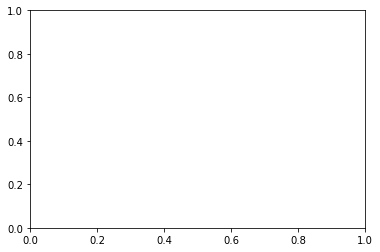

In [21]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

z = TSNE(n_components=2, learning_rate='auto',init='pca',n_iter=10000).fit_transform(x_val)
fig, ax = plt.subplots()
final_error = y_val+np.squeeze(np.rint(final_out))

color = ["green","red","blue"]
label = ["Correct Class 0","Incorrect","Correct Class 1"]
marker = ["o","x","o"]
alpha = [0.3,1,0.3]
for i in range(3):
    ax.scatter(z[final_error==i,0],z[final_error==i,1],np.abs(y_val-np.squeeze(final_out)), c=color[i], label = label[i],marker=marker[i], alpha = alpha[i])
ax.legend()
ax.grid(True)

plt.show()

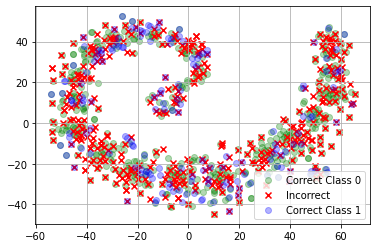

In [22]:
fig, ax = plt.subplots()
color = ["green","red","blue"]
label = ["Correct Class 0","Incorrect","Correct Class 1"]
marker = ["o","x","o"]
alpha = [0.3,1,0.3]

for i in range(3):
    ax.scatter(z[final_error==i,0],z[final_error==i,1], c=color[i], label = label[i],marker=marker[i], alpha = alpha[i])
ax.legend()
ax.grid(True)

plt.show()
fig.savefig("resnet_bert_bagging.jpg")

In [ ]:
color = ["green","red","blue"]
label = ["Correct Class 0","Incorrect","Correct Class 1"]
marker = ["o","x","o"]
alpha = [0.3,1,0.3]
fig, ax = plt.subplots()
ax = fig.add_subplot(projection='3d')
for i in range(3):
    ax.scatter(z[final_error==i,0],z[final_error==i,1],z[final_error==i,2], c=color[i], label = label[i],marker=marker[i], alpha = alpha[i])
ax.legend()
ax.grid(True)

plt.show()

0.6186074429771907